In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit

import matplotlib
from matplotlib import pyplot as plt
import os
import sys

from tqdm import tqdm

In [2]:
import model
import train

# Copy Task

## Problem

Given a repeating sequence of distinct tokens, continue the pattern. This equates to learning an induction head.

## Dataset Generation

The dataset consists of sequences of varying length that contain a repeating pattern and cut-off abruptly. The goal is to continue the sequence correctly. There is no semantic meaning behind tokens, so they can be randomly generated at init and frozen.

E.g. abcabcabca should be continued with bcabcabc

### Base case

The most simple case will simply have 64-character strings containing repeating character sequences of 4 to 15 distinct characters, so we see 8 to 4 repetitions. To start we can use 32 distinct tokens.

In [3]:
# # create dataset; we need to add masking on the loss function!
# key_d1 = jax.random.PRNGKey(0)

# dataset_name = 'copytask'
# token_arr = jnp.arange(128, dtype=jnp.uint16)
# sample_len = 64
# n_data = 2**19*3
# patt_min = 4
# patt_max = 15
# assert sample_len >= patt_max # so there is at least one repetition
# assert patt_max >= patt_min
# assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

# pattern_inds = []
# masks = []
# for patt_len in range(patt_min, patt_max+1):
#   p = jnp.tile(jnp.arange(patt_len), 1+sample_len//patt_len)[:sample_len]
#   pattern_inds.append(p)
#   m = jnp.ones(sample_len)
#   m = m.at[:patt_len].set(0)
#   masks.append(m)
# pattern_inds = jnp.array(pattern_inds)
# masks = jnp.array(masks)

# key_gen, key_shuffle = jax.random.split(key_d1)
# key_perms = jax.random.split(key_gen, n_data)

# tok_permutations = vmap(lambda k : jax.random.permutation(k, token_arr))(key_perms)
# pattern_inds_expanded = jnp.tile(pattern_inds, (n_data//len(pattern_inds), 1))
# masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

# data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
# data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
# masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
# print(pattern_inds.shape, pattern_inds_expanded.shape, masks_expanded.shape, data.shape)
# data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
# print(data_with_mask.shape)
# val_data_len = n_data//16
# train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
# val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
# try:
#   os.mkdir(dataset_name)
# except:
#   print(f'dataset {dataset_name} already exists')
# train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
# val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

# sample_len, n_data, val_data_len

In [252]:
# create dataset; we need to add masking on the loss function!
key_d1 = jax.random.PRNGKey(0)

dataset_name = 'copytask'
token_arr = jnp.arange(64, dtype=jnp.uint16)
sample_len = 64
n_data = 2**19*3
patt_min = 4
patt_max = 27
assert sample_len >= patt_max # so there is at least one repetition
assert patt_max >= patt_min
assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

tok_special = token_arr[:2] # ensure these always map to inds 0
tok_ptr = token_arr[2:] # these are exchangeable, no semantic meaning
assert len(tok_ptr) >= patt_max

sample_inds = []
masks = []
for patt_len in range(patt_min, patt_max+1):
  pattern_inds = jnp.concatenate([jnp.array([1]), jnp.arange(len(tok_special), patt_len+len(tok_special))])
  p = jnp.tile(pattern_inds, 1+sample_len//patt_len)[:sample_len]
  p = p.at[0].set(0)
  sample_inds.append(p)
  m = jnp.ones_like(p)
  m = m.at[:len(pattern_inds) + 1].set(0)
  masks.append(m)
sample_inds = jnp.array(sample_inds)
masks = jnp.array(masks)

key_gen, key_shuffle = jax.random.split(key_d1)
key_perms = jax.random.split(key_gen, n_data)

tok_permutations = vmap(lambda k : jnp.concatenate([tok_special, jax.random.choice(k, tok_ptr, shape=tok_ptr.shape)]))(key_perms)
pattern_inds_expanded = jnp.tile(sample_inds, (n_data//len(sample_inds), 1))
masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
val_data_len = n_data//16
train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
try:
  os.mkdir(dataset_name)
except:
  print(f'dataset {dataset_name} already exists')
train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

sample_len, n_data, val_data_len, train_ids.shape, val_ids.shape

dataset copytask already exists


(64, 1572864, 98304, (2, 94371840), (2, 6291456))

In [253]:
i = 0
train_ids[0][i*sample_len:(i+1)*sample_len], train_ids[1][i*sample_len:(i+1)*sample_len]

(array([ 0,  2, 47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,
         2, 47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,  2,
        47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,  2, 47,
        33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27], dtype=uint16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint16))

In [254]:
# !rm -rf /content/logs

In [255]:
# %%capture
config = train.TrainConfig(
    input_bin=f"{dataset_name}/train_with_mask.bin",
    input_val_bin=f"{dataset_name}/val_with_mask.bin",
    embd_dim = 128,
    head_dim = 64,
    n_layer = 2,
    block_size = 2*sample_len, # should match the task sequence length so tasks are independently trained on
    batch_size = 64,
    gradient_accumulation_steps = 1,
    max_iters = 20_000,
    eval_iters = 25, # val_data_len // 64, # number of examples // batch_size
    learning_rate = 3e-3,
    min_lr = 1e-5,
    warmup_iters = 500,
    lr_decay_iters = 20_000,
    vocab_size = len(token_arr),
    use_masked_loss = True,
    use_mlp = False,
    off_by_one_attn = False,
    use_pope = True,
    # freeze_params=("wte",),
    max_seq_len = 6*sample_len,

    pos_encoding_base = 1_000,
    
    log_interval = 10_000,
    eval_interval = 1_000,
)
display(config)

TrainConfig(mesh_axis_names=('dp',), mesh_shape=(4,), input_bin='copytask/train_with_mask.bin', input_val_bin='copytask/val_with_mask.bin', wandb_project='gpt-jax', wandb_entity=None, wandb_run_name=None, wandb_group=None, wandb_job_type=None, wandb_tags=(), wandb_notes=None, wandb_mode='online', wandb_log_code=True, max_iters=20000, warmup_iters=500, lr_decay_iters=20000, eval_interval=1000, eval_iters=25, log_interval=10000, save_every=0, batch_size=64, gradient_accumulation_steps=1, learning_rate=0.003, min_lr=1e-05, weight_decay=0.1, beta1=0.9, beta2=0.95, grad_clip=1.0, n_layer=2, embd_dim=128, head_dim=64, block_size=128, vocab_size=64, dropout=0.0, max_seq_len=384, pos_encoding_base=1000, use_mlp=False, off_by_one_attn=False, use_pope=True, seed=1337, use_masked_loss=True, freeze_params=())

In [256]:
params = train.train_loop(config)

socket.send() raised exception.
socket.send() raised exception.


[wandb] No credentials found. Falling back to offline mode.
[wandb] init failed (BrokenPipeError: [Errno 32] Broken pipe). Disabling W&B.
Number of parameters: 0.14M
No parameter freezing applied
Loading training data...
Process 0/1 prepared dataset from 1 file(s): 94,371,840 tokens, 0.38 GB on disk.
Process 0/1 prepared loader with 20000 batches.
Loaded 20000 training batches.
Loading validation data...
Process 0/1 prepared dataset from 1 file(s): 6,291,456 tokens, 0.03 GB on disk.
Process 0/1 prepared loader with 25 batches.
Loaded 25 validation batches.
Starting Ahead-of-Time (AOT) compilation...
AOT compilation finished.
Starting training...
Running validation for step 0...
model/total_params: 139392 | model/attn_params: 131072 | model/mlp_params: 0 | model/embed_params: 8192 | model/vocab_size: 64 | val_loss: 4.269 | step: 0 | lr: 0 | loss: 4.274
Running validation for step 1000...
val_loss: 2.798
Running validation for step 2000...
val_loss: 2.593
Running validation for step 3000

In [263]:
test_input = jnp.array([0]+[3,9,8,3,4,4,4,8,5,8,6,6,8,8,2,7], dtype=jnp.uint16)
patt_len = len(test_input)
print('patt_len', patt_len)
res = jnp.zeros(config.max_seq_len, dtype=jnp.uint16)
res = res.at[:patt_len].set(test_input).at[patt_len].set(1)

rope_params = model.precompute_pope(config.get_model_config(), None) if config.use_pope else model.precompute_rope(config.get_model_config(), None)
for i in tqdm(range(patt_len, len(res))):
  preds = model.gpt_forward(params, rope_params, res[None,:], config.get_model_config())
  new_ind = jnp.argmax(preds[0][i])
  res = res.at[i+1].set(new_ind if ((i+1) % patt_len > 0) else 1)

preds, attn_weights = model.gpt_forward(params, rope_params, res[None,:], config.get_model_config(), return_attn_weights=True)

patt_len 17


  0%|          | 0/367 [00:00<?, ?it/s]/home/nikola.georgiev2000/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 367/367 [00:06<00:00, 54.26it/s]


In [264]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=0, ha="right", rotation_mode="anchor", fontsize=8)
    ax.set_yticks(range(data.shape[0]), labels=row_labels, fontsize=8)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

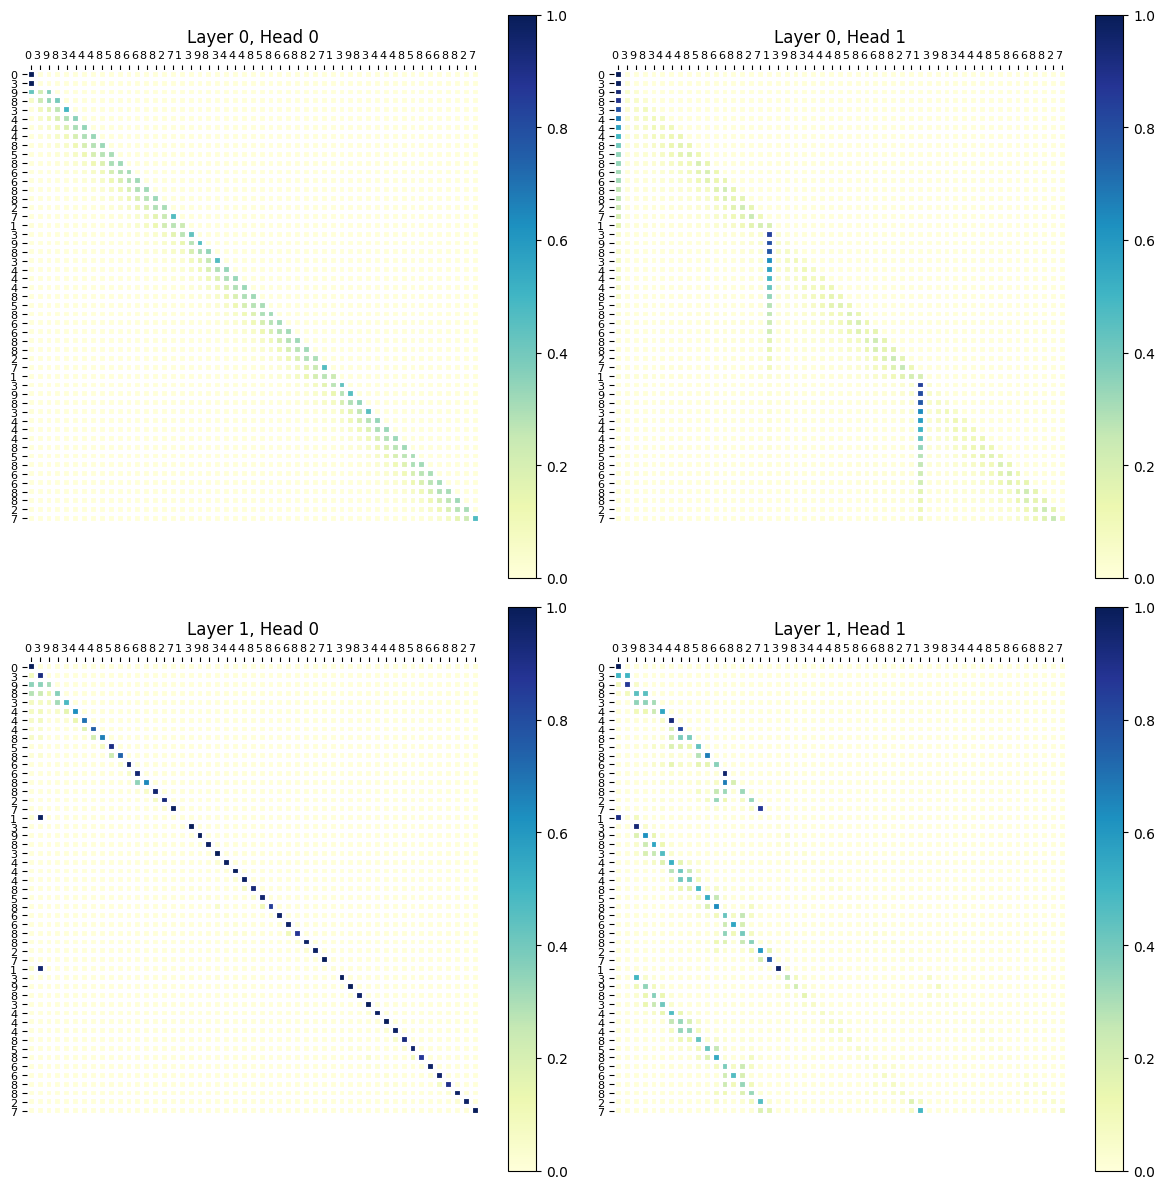

In [269]:
subset = jnp.arange(3*patt_len)

# Determine num_layers and num_heads from attn_weights structure
num_layers = len(attn_weights)
num_heads = attn_weights[0][0].shape[0]  # Assuming shape: [num_heads, seq, seq]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(6 * num_heads, 6 * num_layers), squeeze=False)

for l in range(num_layers):
    for h in range(num_heads):
        selected_attn = attn_weights[l][0][h][subset[:, None], subset[None, :]]
        ax = axes[l, h]
        im, cbar = heatmap(
            selected_attn,
            res[subset], res[subset], ax=ax,
            cmap="YlGnBu"
        )
        ax.set_title(f"Layer {l}, Head {h}")

fig.tight_layout()
plt.show()


<BarContainer object of 64 artists>

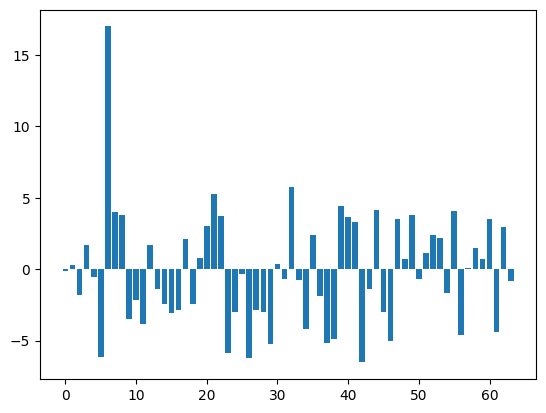

In [266]:
plt.bar(jnp.arange(preds.shape[-1]), preds[0][44])

In [274]:
res = jnp.array(res)

print("Testing input:")
print(f'{0:2d}: {test_input}')

print("Predicted output:")
for i, l in enumerate(res[patt_len: len(res) - (len(res)%patt_len)].reshape(-1, patt_len)):
    # format so index strings are aligned
    print(f'{i+1:2d}: {l} - {"✅" if (l - test_input).sum() == 1 else "❌"}')

Testing input:
 0: [0 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7]
Predicted output:
 1: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 2: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 3: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 4: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 5: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 6: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 7: [1 3 9 8 3 4 4 4 8 5 8 6 6 8 8 2 7] - ✅
 8: [1 3 9 8 3 4 4 4 8 5 8 6 8 2 7 1 3] - ❌
 9: [1 3 9 8 3 4 4 4 8 5 8 6 8 2 7 1 3] - ❌
10: [1 3 9 8 3 4 4 4 8 5 8 6 8 2 7 1 3] - ❌
11: [1 3 9 8 3 4 4 8 2 7 1 3 9 8 3 1 3] - ❌
12: [1 3 9 8 3 4 8 2 7 1 3 9 8 3 1 3 9] - ❌
13: [1 3 9 8 3 3 1 3 9 8 3 1 3 9 8 3 1] - ❌
14: [1 3 9 8 3 1 1 1 3 9 8 3 1 1 1 3 9] - ❌
15: [1 1 3 9 8 3 1 1 1 3 9 8 3 1 9 8 3] - ❌
16: [1 9 8 3 1 9 8 3 1 9 8 3 1 9 8 3 1] - ❌
17: [1 9 8 3 1 9 8 3 1 9 8 3 1 9 8 3 1] - ❌
18: [1 9 8 3 1 9 8 3 1 9 8 3 1 9 8 3 1] - ❌
19: [1 9 8 3 1 9 8 3 1 9 8 3 1 9 8 3 1] - ❌
20: [1 9 8 3 1 9 8 3 1 9 8 3 1 9 8 3 1] - ❌
21: [1 9 8 3 1 1 9 8 3 1 1 9 8 3 1 1 9] - ❌


### QUESTION

What's the better way to encode the Copy Task for generalizing to longer sequences?

1. End all patterns with the special token (0). A possible algorithm to learn is to check if there is a 0 in context and if not, record the previous token. If yes, just query and copy based on context. If we don't use off-by-one attention, the first token will likely be a sink token, which might hurt performance.
2. Start patterns with special tokens, 0 for the input and 1 for outputs (copied from the input). This will likely result in a sink token at the first position.


### TODO

Add a better long-context Copy Task dataset with many examples to properly test generalization.
Do a sweep over learning rates, embedding sizes, number of attention heads, number of layers.

Should I try a different position encoding? Seems like the model struggles to learn the n-grams need copying.

# Path Graph

## Problem

Given a 'goal' token, identify which unique 'path' in context it comes from and return all tokens in the path up to and including the goal.

Concretely, suppose your context has two paths: A,B,C and P,Q,R,S. Given a goal R, we would return P,Q,R. This tests the model's ability to build pointers between tokens based on context.

## Dataset Generation

The dataset consists of a list of sequences. Sequences can be one of three types:
- context
- input
- output

No nesting of sequences is allowed.

#### Tokenization

Overall will use 128 tokens.

Special Tokens (with index):
- Context Start: 0
- Input Start: 1
- Output start: 2

Each special token implicitly ends the previous sequence and starts a new one. These embeddings can be learned.

All remaining tokens are exchangeable, i.e. only act as pointers and contain no semantic meaning. Their embeddings will be fixed and initialized randomly.

1. Minimal example
- 0, 3,4,5,6, 1, 5, 2, 3,4,5

2. Two contexts
- 0, 3,4,5,6, 0, 7,8,9, 1, 4, 2, 3,4

3. Stream of problems (context grows and problems arrive independently)
- 0, 3,4,5,6, 0, 7,8,9, 1, 5, 2, 3,4,5, 0, 10,11,12,13,14, 1, 4, 2, 3,4, 1, 12, 2, 10,11,12

For position encoding we'll use RoPE which works well with QK-norm attention.

In [268]:
# TBD, need to add masking to loss_fn()!